# Cross-Tissue Methylation Patterns of Clock CpGS

Compare the methylation levels of these CpGs across different tissues to identify any consistent patterns or variations

In [1]:
#### LOAD: libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns

import itertools
from itertools import combinations

from pathlib import Path

import matplotlib.cm as cm  
from matplotlib import colormaps as mcolors
import matplotlib.pyplot as plt

from matplotlib import colormaps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import pandas as pd
import numpy as np
from scipy import stats
import os
import joblib

from matplotlib_venn import venn3
import matplotlib.pyplot as plt



## 0. Load the data

In [144]:
#### LOAD: Metadata
metadata = pd.read_csv('GSE223748_complete_metadata.csv')

In [145]:
#### LOAD: Complete methylation data

complete_methylation = pd.read_csv('GSE223748_datBetaNormalized.csv')
complete_methylation.rename(columns={'Unnamed: 0': 'CpG'}, inplace=True)

In [218]:
#### LOAD: Tissue-specific methylation datasets from the saved CSV files

folder_name = "Tissue Methylation"
tissue_files = os.listdir(folder_name) # Get a list of all files in the folder
tissues_df = metadata[['Sample', 'Tissue']]
tissues = tissues_df['Tissue'].unique() # Get a list of all tissues

# Load each CSV file into its own dataframe
for file in tissue_files:
    if file.endswith("_methylation_dataset.csv"):
        # Extract tissue name from file name
        tissue = file.split("_")[0]

        # Load CSV file into dataframe
        file_path = os.path.join(folder_name, file)
        globals()['{}_methylation_dataset'.format(tissue)] = pd.read_csv(file_path)

In [242]:
#### LOAD: Methylation data for the complete CpGs of each clock
clock1 = pd.read_csv('./Clocks Methylation Data/Clock1_Methylation_data_complete.csv') 
clock2 = pd.read_csv('./Clocks Methylation Data/Clock2_Methylation_data_complete.csv')
clock3 = pd.read_csv('./Clocks Methylation Data/Clock3_Methylation_data_complete.csv')
clock2_3 = pd.read_csv('./Clocks Methylation Data/Clock2_3_Overlap_Methylation_data_complete.csv')

In [246]:
print(f'Total number of CpGs in Clock 1: {len(clock1)}')
print(f'Total number of CpGs in Clock 2: {len(clock2)}')
print(f'Total number of CpGs in Clock 3: {len(clock3)}')
print(f'Total number of CpGs in Clock 2 & 3 overlap: {len(clock2_3)}')

Total number of CpGs in Clock 1: 335
Total number of CpGs in Clock 2: 816
Total number of CpGs in Clock 3: 760
Total number of CpGs in Clock 2 & 3 overlap: 401


In [220]:
### Filter the complete methylation dataset by the CpGs in each clock

# Define a function to filter methylation data by CpGs in a given clock
def filter_by_clock(complete_methylation, clock_cpgs):
    return complete_methylation[complete_methylation['CpG'].isin(clock_cpgs)]

# Filter the datasets 
complete_methylation_dataset_clock1_filtered = filter_by_clock(complete_methylation, clock1['CpG'].values)
complete_methylation_dataset_clock2_filtered = filter_by_clock(complete_methylation, clock2['CpG'].values)
complete_methylation_dataset_clock3_filtered = filter_by_clock(complete_methylation, clock3['CpG'].values)
complete_methylation_dataset_clock2_3_filtered = filter_by_clock(complete_methylation, clock2_3['CpG'].values)

In [221]:
### Create a dataframe that stores the tissue-specific datasets for each clock

# Filter the all tissue-specific datasets by the CpGs in each clock
clocks = {
    'clock1': clock1['CpG'].values,
    'clock2': clock2['CpG'].values,
    'clock3': clock3['CpG'].values,
    'clock2_3': clock2_3['CpG'].values
}

tissues = tissues_df['Tissue'].unique() # Get a list of all tissues
tissue_datasets = pd.DataFrame(columns=['Tissue', 'Clock', 'Dataset']) # create a dataframe to store the datasets

# List of tissues not included
tissues_not_included = []

# fill the dictionary with dataset and respective tissue name
for tissue in tissues:
    if metadata[metadata['Tissue'] == tissue].shape[0] < 10:
        tissues_not_included.append(tissue)
    else:
        for clock_name, clock_cpgs in clocks.items():
            tissue_df = globals()['{}_methylation_dataset'.format(tissue)].copy()
            tissue_df = tissue_df[tissue_df['CpG'].isin(clock_cpgs)]
            tissue_datasets.loc[len(tissue_datasets)] = [tissue, clock_name, tissue_df]

            # Define a variable for each of the datasets dynamically
            variable_name = f'{tissue.lower()}_{clock_name}_dataset'
            globals()[variable_name] = tissue_df

print('Tissues not included:', tissues_not_included)
print('Total number of tissues not included:', len(tissues_not_included))
tissue_datasets.head()

# Note to self: to access any of he tissue-specific datasets, use the variable name in the format: {tissue}_{clock}_dataset (cortex_clock1_dataset)

Tissues not included: ['Testis', 'Pancreas', 'Thyroid', 'Blubber', 'Ileum', 'Duodenum', 'Tendon', 'Mammary', 'TemporalCortex', 'Lamina', 'OccipitalCortex', 'ParietalCortex', 'MitralValve', 'AdrenalCortex', 'Sacrocaudalis', 'Cecum', 'Uterus', 'Jejunum', 'Larynx', 'SpinalCord', 'Suspensory', 'Cartilage', 'Astrocyte', 'Epidermis', 'Dermis', 'Maybe.Larynx']
Total number of tissues not included: 26


,Tissue,Clock,Dataset
0,Cortex,clock1,CpG 202794570001_R01C01 202794...
1,Cortex,clock2,CpG 202794570001_R01C01 202794...
2,Cortex,clock3,CpG 202794570001_R01C01 202794...
3,Cortex,clock2_3,CpG 202794570001_R01C01 202794...
4,Liver,clock1,CpG 202794570002_R01C01 202794...


In [222]:
cortex_clock2_dataset.head()

,CpG,202794570001_R01C01,202794570001_R01C02,202794570001_R02C01,202794570001_R02C02,202794570001_R03C01,202794570001_R03C02,202794570001_R04C01,202794570001_R04C02,202794570001_R05C01,...,205483080037_R03C01,205483080037_R03C02,205483080037_R04C01,205483080037_R04C02,205483080037_R05C01,205483080037_R05C02,205483080037_R06C01,205483080037_R06C02,205619060097_R03C02,205863120005_R02C01
29,cg00020468,0.946976,0.932568,0.940156,0.931719,0.946127,0.938136,0.939809,0.936536,0.934102,...,0.901696,0.891315,0.915935,0.898451,0.904993,0.904087,0.905966,0.914124,0.846523,0.974230
141,cg00096922,0.056694,0.044397,0.051426,0.055706,0.053108,0.045419,0.053473,0.058857,0.054962,...,0.084162,0.096882,0.090080,0.087188,0.107595,0.096832,0.091701,0.088679,0.079580,0.060907
142,cg00098422,0.927504,0.918589,0.922592,0.934535,0.940001,0.943838,0.919849,0.941314,0.939990,...,0.688974,0.703023,0.745666,0.692923,0.709489,0.698925,0.714697,0.694821,0.621427,0.935314
156,cg00106940,0.007289,0.006400,0.007009,0.006729,0.007864,0.010078,0.008794,0.007826,0.007798,...,0.009432,0.006330,0.011899,0.009694,0.007567,0.006383,0.009143,0.012623,0.004884,0.004949
279,cg00195533,0.431196,0.496208,0.448819,0.459928,0.447120,0.374721,0.516643,0.382831,0.418710,...,0.311930,0.320773,0.308253,0.352051,0.290556,0.278814,0.336782,0.288139,0.070926,0.063472


## 1. Data Analysis

In [223]:
### Function to analyze methylation patterns

def analyze_methylation_patterns(tissue_datasets, clock_name, output_folder):
    try:
        # Create output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)
        
        # Filter datasets for the specific clock
        clock_data = tissue_datasets[tissue_datasets['Clock'] == clock_name]
        
        # Create a dictionary to store summary statistics for each tissue
        summary_stats = {}
        
        for _, row in clock_data.iterrows():
            tissue = row['Tissue']
            dataset = row['Dataset']
            
            # Ensure 'CpG' is the index and samples are columns
            if dataset.index.name != 'CpG':
                dataset = dataset.set_index('CpG')
            
            # Calculate summary statistics
            summary = dataset.agg(['mean', 'median', 'std', lambda x: x.max() - x.min()], axis=1)
            summary.columns = ['mean', 'median', 'std', 'range']
            summary_stats[tissue] = summary
        
        # Combine summary statistics into a single dataframe
        combined_stats = pd.concat(summary_stats, axis=1)
        
        # Save combined stats
        combined_stats.to_csv(os.path.join(output_folder, f'{clock_name}_combined_stats.csv'))
        
        # Calculate and save mean methylation
        mean_methylation = pd.DataFrame({tissue: data['mean'] for tissue, data in summary_stats.items()})
        mean_methylation.to_csv(os.path.join(output_folder, f'{clock_name}_mean_methylation.csv'))
        
        # Identify consistent patterns
        mean_methylation_across_tissues = mean_methylation.mean(axis=1)
        
        high_methylation = mean_methylation_across_tissues[mean_methylation_across_tissues > 0.8]
        low_methylation = mean_methylation_across_tissues[mean_methylation_across_tissues < 0.2]
        
        # More stringent: 5th to 95th percentile with a higher threshold
        methylation_range = mean_methylation.quantile(0.90, axis=1) - mean_methylation.quantile(0.1, axis=1)
        variable_cpgs = methylation_range[methylation_range > 0.1]
        
        # Save consistent patterns
        pd.Series({'high_methylation': len(high_methylation),
                   'low_methylation': len(low_methylation),
                   'variable_cpgs': len(variable_cpgs)}).to_csv(os.path.join(output_folder, f'{clock_name}_consistent_patterns.csv'))
        
        # Statistical test (ANOVA)
        def anova_test(cpg):
            try:
                groups = [tissue_data.loc[cpg] for tissue_data in summary_stats.values() if cpg in tissue_data.index]
                if len(groups) > 1:
                    f_value, p_value = stats.f_oneway(*groups)
                    return p_value
                else:
                    print(f"Not enough data for ANOVA for CpG: {cpg}")
                    return np.nan
            except KeyError:
                print(f"KeyError: '{cpg}' not found in one of the tissue datasets.")
                return np.nan
        
        # Use CpG names from the index of mean_methylation
        cpg_names = mean_methylation.index
        anova_results = pd.Series({cpg: anova_test(cpg) for cpg in cpg_names})
        significant_cpgs = anova_results[anova_results < 0.01]
        
        # Save ANOVA results
        anova_results.to_csv(os.path.join(output_folder, f'{clock_name}_anova_results.csv'))
        significant_cpgs.to_csv(os.path.join(output_folder, f'{clock_name}_significant_cpgs.csv'))
        
        print(f"Analysis for {clock_name} complete. Results saved in {output_folder}")

        return {
            'high_methylation': high_methylation,
            'low_methylation': low_methylation,
            'variable_cpgs': variable_cpgs,
            'mean_methylation': mean_methylation
        }
    
    except Exception as e:
        print(f"An error occurred during analysis of {clock_name}: {str(e)}")
        return None

In [225]:
# Perform analysis for each clock and store results

# Perform analysis for each clock and store results
output_base_folder = 'Cross-Tissue Methylation Patterns'
os.makedirs(output_base_folder, exist_ok=True)

analysis_results = {}

for clock_name in clocks.keys():
    print(f"\nAnalyzing {clock_name}...")
    output_folder = os.path.join(output_base_folder, clock_name)
    result = analyze_methylation_patterns(tissue_datasets, clock_name, output_folder)
    if result is not None:
        analysis_results[clock_name] = result
    else:
        print(f"Analysis failed for {clock_name}")

print('\nAnalysis Complete')

# # Perform analysis for each clock

# # List of clocks with their respective CpGs
# # clocks = {
# #     'clock1': clock1['CpG'].values,
# #     'clock2': clock2['CpG'].values,
# #     'clock3': clock3['CpG'].values,
# #     'clock2_3': clock2_3['CpG'].values
# # }

# output_base_folder = 'Cross-Tissue Methylation Patterns'
# os.makedirs(output_base_folder, exist_ok=True)

# for clock_name in clocks.keys():
#     print(f"\nAnalyzing {clock_name}...")
#     output_folder = os.path.join(output_base_folder, clock_name)
#     analyze_methylation_patterns(tissue_datasets, clock_name, output_folder)

# print('\nAnalysis Complete')


Analyzing clock1...
Analysis for clock1 complete. Results saved in Cross-Tissue Methylation Patterns\clock1

Analyzing clock2...
Analysis for clock2 complete. Results saved in Cross-Tissue Methylation Patterns\clock2

Analyzing clock3...
Analysis for clock3 complete. Results saved in Cross-Tissue Methylation Patterns\clock3

Analyzing clock2_3...
Analysis for clock2_3 complete. Results saved in Cross-Tissue Methylation Patterns\clock2_3

Analysis Complete


In [226]:
### Function to create visualizations 

def create_visualizations(clock_name, output_folder):
    # Load data
    mean_methylation = pd.read_csv(os.path.join(output_folder, f'{clock_name}_mean_methylation.csv'), index_col=0)
    
    # Transpose mean_methylation to have tissues on x-axis and CpGs on y-axis
    mean_methylation_transposed = mean_methylation.transpose()



    ##### HEATMAP #####
    
    # Heatmap of mean methylation levels
    plt.figure(figsize=(20, 10))
    sns.heatmap(mean_methylation_transposed, cmap='coolwarm', center=0.5)
    plt.title(f'Mean Methylation Levels Across Tissues - {clock_name}',
              fontsize=15,
              fontweight='bold',
              pad=20)
    plt.xticks(rotation=90)
    plt.ylabel('Tissue')
    # plt.colorbar(label='Mean Methylation Level')
    plt.savefig(os.path.join(output_folder, f'{clock_name}_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.close()



    ##### CLUSTERMAP #####

    # Heatmaps of mean methylation levels for each tissue with clustermap
    plt.figure(figsize=(20, 10))
    clustergrid = sns.clustermap(mean_methylation_transposed, 
                   cmap='coolwarm', center=0.5, 
                   cbar_pos=(.75, .61, .03, .20), #[left, bottom, width, height]
                   vmin=0, vmax=1,
                   cbar_kws={'label': 'Mean Methylation Level'},
                   yticklabels=True
                   )
    plt.title(f'Mean Methylation Levels Across Tissues (Clustermap) - {clock_name.capitalize()}',
              fontsize=15,
              fontweight='bold', 
              loc='right',
              pad=20)
    clustergrid.ax_row_dendrogram.set_visible(False)
    clustergrid.ax_col_dendrogram.set_visible(False)

    # Move y-axis labels to the left
    plt.setp(clustergrid.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    clustergrid.ax_heatmap.yaxis.tick_left()
    
    plt.savefig(os.path.join(output_folder, f'{clock_name}_clustermap.png'), dpi=300, bbox_inches='tight')
    plt.close()
    


    ##### BOXPLOT #####

    # Box plot of mean methylation levels
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=mean_methylation, orient='h', palette='viridis')
    plt.title(f'Distribution of Mean Methylation Levels Across Tissues - {clock_name}',
              fontsize=15,
              fontweight='bold',
              pad=20)
    plt.xlabel('Mean Methylation Level')
    plt.ylabel('Tissue')
    plt.savefig(os.path.join(output_folder, f'{clock_name}_boxplot.png'), dpi=300, bbox_inches='tight')
    plt.close()



    ##### CORRELATION MATRIX #####

    # Correlation analysis (using the original mean_methylation dataframe)
    correlation_matrix = mean_methylation.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
    plt.title(f'Correlation of Methylation Patterns Between Tissues - {clock_name}',
              fontsize=15,
              fontweight='bold',
              pad=20)
    plt.savefig(os.path.join(output_folder, f'{clock_name}_correlation.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Visualizations for {clock_name} complete. Saved in {output_folder}")

In [227]:
### Create Visualizations

output_base_folder = 'Cross-Tissue Methylation Patterns'

# Loop just the fisrt 2 clocks
for clock_name in clocks.keys():
# for clock_name in clocks.keys():

    print(f"\nCreating visualizations for {clock_name}...")

    output_folder = os.path.join(output_base_folder, clock_name)
    
    create_visualizations(clock_name, output_folder)

    print(f"\nVisualizations for {clock_name} complete. Saved in {output_folder}")


Creating visualizations for clock1...
Visualizations for clock1 complete. Saved in Cross-Tissue Methylation Patterns\clock1

Visualizations for clock1 complete. Saved in Cross-Tissue Methylation Patterns\clock1

Creating visualizations for clock2...
Visualizations for clock2 complete. Saved in Cross-Tissue Methylation Patterns\clock2

Visualizations for clock2 complete. Saved in Cross-Tissue Methylation Patterns\clock2

Creating visualizations for clock3...
Visualizations for clock3 complete. Saved in Cross-Tissue Methylation Patterns\clock3

Visualizations for clock3 complete. Saved in Cross-Tissue Methylation Patterns\clock3

Creating visualizations for clock2_3...
Visualizations for clock2_3 complete. Saved in Cross-Tissue Methylation Patterns\clock2_3

Visualizations for clock2_3 complete. Saved in Cross-Tissue Methylation Patterns\clock2_3


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

## 2. Results

### 2.1. Summary

In [228]:
### Summary of CpGs with consistent methylation patterns

# Summary of CpGs with consistent methylation patterns
for clock_name, results in analysis_results.items():

    high_methylation = results['high_methylation'] # CpGs with high methylation
    low_methylation = results['low_methylation'] # CpGs with low methylation
    variable_cpgs = results['variable_cpgs'] # CpGs with variable methylation
    mean_methylation = results['mean_methylation'] # Mean methylation levels across tissues

    # Store the CpG indices and mean methylation values
    high_methylation_cpgs[clock_name] = pd.DataFrame({
        'CpG': high_methylation.index, # CpG names
        'Mean Methylation': high_methylation.values # Mean methylation values
    })

    low_methylation_cpgs[clock_name] = pd.DataFrame({
        'CpG': low_methylation.index,
        'Mean Methylation': low_methylation.values
    })

    variable_methylation_cpgs[clock_name] = pd.DataFrame({
        'CpG': variable_cpgs.index,
        'Mean Methylation': mean_methylation.mean(axis=1)[variable_cpgs.index].values # Mean methylation values for variable CpGs only
    })

    # Print results
    print(f"\n{clock_name.upper()}")
    print(f"Number of CpGs consistently highly methylated across tissues in {clock_name}: {len(high_methylation_cpgs[clock_name])}")
    print(f"Number of CpGs consistently lowly methylated across tissues in {clock_name}: {len(low_methylation_cpgs[clock_name])}")
    print(f"Number of CpGs with highly variable methylation across tissues in {clock_name}: {len(variable_methylation_cpgs[clock_name])}")


CLOCK1
Number of CpGs consistently highly methylated across tissues in clock1: 68
Number of CpGs consistently lowly methylated across tissues in clock1: 94
Number of CpGs with highly variable methylation across tissues in clock1: 244

CLOCK2
Number of CpGs consistently highly methylated across tissues in clock2: 238
Number of CpGs consistently lowly methylated across tissues in clock2: 257
Number of CpGs with highly variable methylation across tissues in clock2: 561

CLOCK3
Number of CpGs consistently highly methylated across tissues in clock3: 216
Number of CpGs consistently lowly methylated across tissues in clock3: 241
Number of CpGs with highly variable methylation across tissues in clock3: 510

CLOCK2_3
Number of CpGs consistently highly methylated across tissues in clock2_3: 125
Number of CpGs consistently lowly methylated across tissues in clock2_3: 119
Number of CpGs with highly variable methylation across tissues in clock2_3: 274


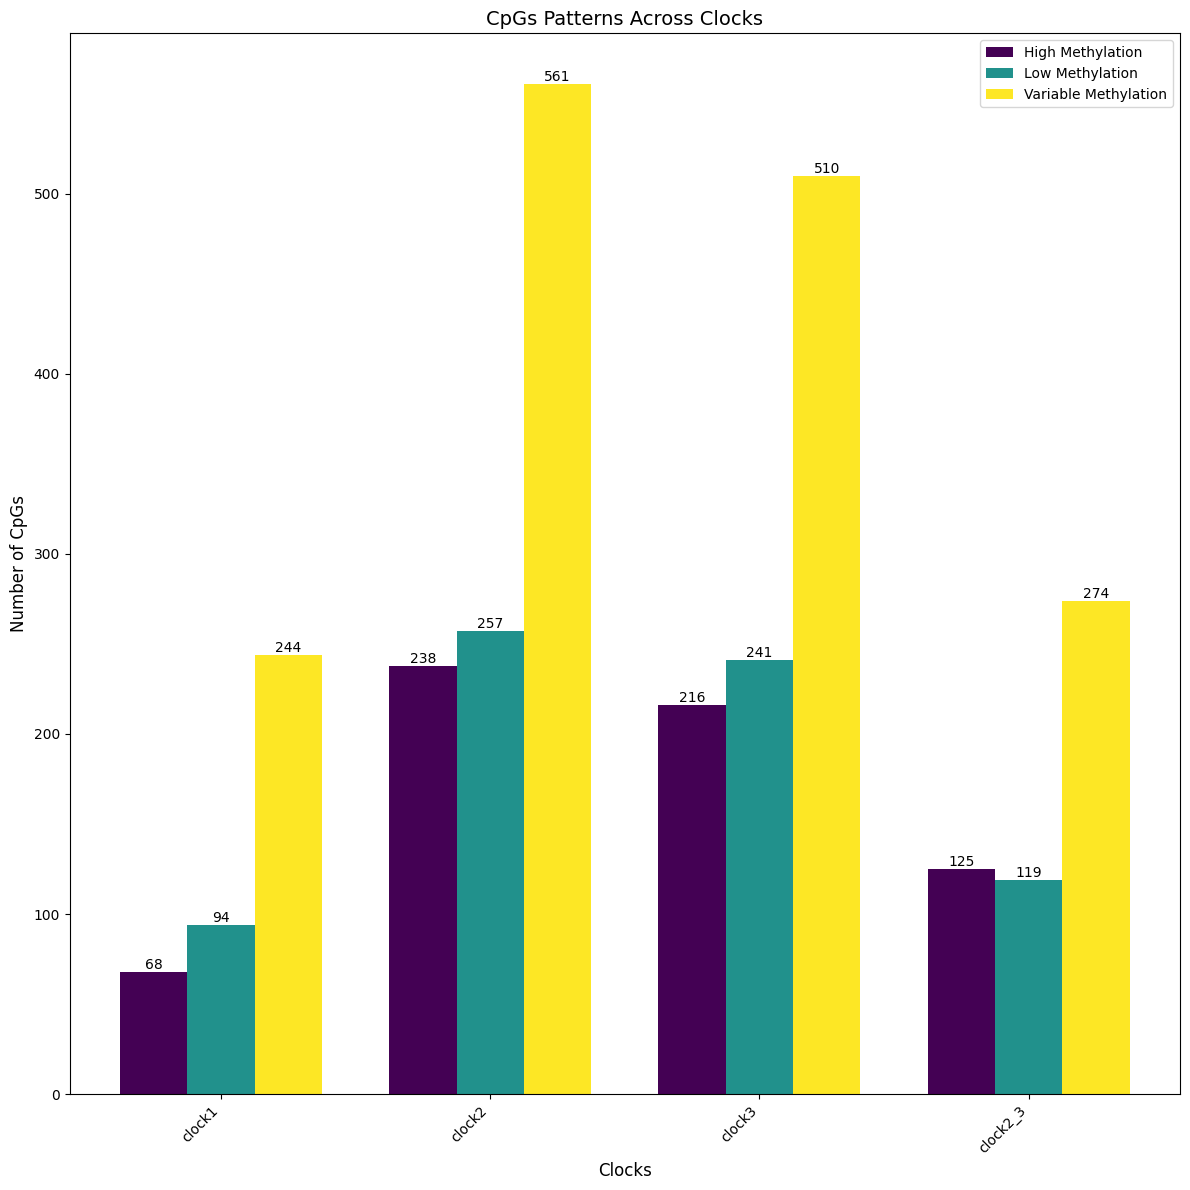

In [245]:
### Bar plot of the number of CpGs with consistent methylation patterns

# Data for the bar plot
clocks = list(analysis_results.keys())

high_methylation = [len(results['high_methylation']) for results in analysis_results.values()]
low_methylation = [len(results['low_methylation']) for results in analysis_results.values()]
variable_methylation = [len(results['variable_cpgs']) for results in analysis_results.values()]

x = range(len(clocks))

fig, ax = plt.subplots(figsize=(12, 12))

bar_width = 0.25

# Apply the viridis colormap
viridis = colormaps.get_cmap('viridis')
colors = [viridis(i / 2) for i in range(3)]  # Generate 3 distinct colors from the colormap

# Plot the bars with viridis colors
ax.bar(x, high_methylation, width=bar_width, label='High Methylation', color=colors[0])
ax.bar([p + bar_width for p in x], low_methylation, width=bar_width, label='Low Methylation', color=colors[1])
ax.bar([p + 2 * bar_width for p in x], variable_methylation, width=bar_width, label='Variable Methylation', color=colors[2])

# Set the labels and title
ax.set_xlabel('Clocks', fontsize=12)
ax.set_ylabel('Number of CpGs', fontsize=12)
ax.set_title('CpGs Patterns Across Clocks', fontsize=14)
ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(clocks, rotation=45, ha='right')
ax.legend(fontsize=10)

# Add value labels on top of each bar
for i, v in enumerate(high_methylation):
    ax.text(i, v, str(v), ha='center', va='bottom')
for i, v in enumerate(low_methylation):
    ax.text(i + bar_width, v, str(v), ha='center', va='bottom')
for i, v in enumerate(variable_methylation):
    ax.text(i + 2 * bar_width, v, str(v), ha='center', va='bottom')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### 2.2. High Methylation CpGs in All Tissues

In [230]:
### CpGs that are highly methylated in all clocks

# Get the set of highly methylated CpGs for each clock
high_methylated_sets = {clock: set(df['CpG']) for clock, df in high_methylation_cpgs.items()}

# Convert the CpGs to strings to avoid hash errors and exclude clock2_3 
clock1 = set(str(cpg) for cpg in high_methylated_sets['clock1'])
clock2 = set(str(cpg) for cpg in high_methylated_sets['clock2'])
clock3 = set(str(cpg) for cpg in high_methylated_sets['clock3'])
# clock2_3 = set(str(cpg) for cpg in high_methylated_sets['clock2_3']) # Not used at it already is an overlap of two clocks

# Find the intersection of all sets
all_clocks_high_methylated_cpgs = set.intersection(clock1, clock2, clock3) #instead of set.intersection(*high_methylated_sets.values()) as this pulls all the clocks and I dont want to include clock2_3

# Convert the result to a list if needed
all_clocks_high_methylated_cpgs = list(all_clocks_high_methylated_cpgs)

# Set the output folder
output_folder = 'Cross-Tissue Methylation Patterns'
os.makedirs(output_folder, exist_ok=True)

# save the list to a csv file
all_clocks_high_methylated_cpgs_df = pd.DataFrame(all_clocks_high_methylated_cpgs, columns=['CpG'])
all_clocks_high_methylated_cpgs_df.to_csv(os.path.join(output_folder, 'all_clocks_high_methylated_cpgs.csv'), index=False)

# Print the result
print(f"\nNumber of CpGs consistently highly methylated across all clocks: {len(all_clocks_high_methylated_cpgs)}")
print("CpGs consistently highly methylated across all clocks:")
print(all_clocks_high_methylated_cpgs)



Number of CpGs consistently highly methylated across all clocks: 17
CpGs consistently highly methylated across all clocks:
['cg15340018', 'cg17114460', 'cg05401971', 'cg03820088', 'cg27547112', 'cg06004718', 'cg12382554', 'cg19195912', 'cg12449245', 'cg14701342', 'cg17718834', 'cg14443903', 'cg17357006', 'cg21907062', 'cg17516812', 'cg23778391', 'cg06679868']


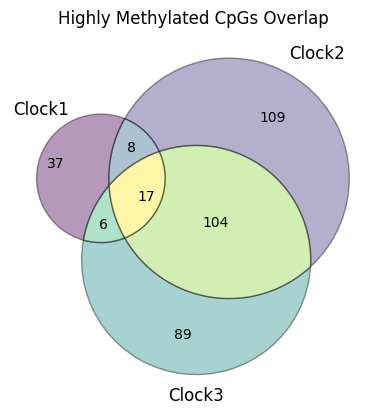

In [231]:
### Venn diagram of highly methylated CpGs across clocks

# Select the CpGs that are highly methylated in each clock
venn = venn3([high_methylated_sets['clock1'], high_methylated_sets['clock2'], high_methylated_sets['clock3']],
      ('Clock1', 'Clock2', 'Clock3'))

# Apply the viridis colormap
viridis = colormaps.get_cmap('viridis')  # Get the viridis colormap

# Generate 7 colors from the colormap
colors = [viridis(i / 6) for i in range(7)]

# Set colors for the Venn diagram areas
for i, patch in enumerate(venn.patches):
    if patch is not None:
        patch.set_color(colors[i])
        patch.set_edgecolor('black')  # Optionally add a border for better visualization
        
plt.title('Highly Methylated CpGs Overlap')
plt.show()


### 2.3. Low Methylation CpGs in All Tissues

In [232]:
### CpG that are lowly methylated in all clocks

# Get the set of lowly methylated CpGs for each clock
low_methylated_sets = {clock: set(df['CpG']) for clock, df in low_methylation_cpgs.items()}

# Convert the CpGs to strings to avoid hash errors and exclude clock2_3
clock1 = set(str(cpg) for cpg in low_methylated_sets['clock1'])
clock2 = set(str(cpg) for cpg in low_methylated_sets['clock2'])
clock3 = set(str(cpg) for cpg in low_methylated_sets['clock3'])
# clock2_3 = set(str(cpg) for cpg in low_methylated_sets['clock2_3']) # Not used at it already is an overlap of two clocks

# Find the intersection of all sets
all_clocks_low_methylated_cpgs = set.intersection(clock1, clock2, clock3) #instead of set.intersection(*low_methylated_sets.values()) as this pulls all the clocks and I dont want to include clock2_3

# Convert the result to a list if needed
all_clocks_low_methylated_cpgs = list(all_clocks_low_methylated_cpgs)

# Set the output folder
output_folder = 'Cross-Tissue Methylation Patterns'
os.makedirs(output_folder, exist_ok=True)

# save the list to a csv file
all_clocks_low_methylated_cpgs_df = pd.DataFrame(all_clocks_low_methylated_cpgs, columns=['CpG'])
all_clocks_low_methylated_cpgs_df.to_csv(os.path.join(output_folder, 'all_clocks_low_methylated_cpgs.csv'), index=False)

# Print the result
print(f"\nNumber of CpGs consistently lowly methylated across all clocks: {len(all_clocks_low_methylated_cpgs)}")
print("CpGs consistently lowly methylated across all clocks:")
print(all_clocks_low_methylated_cpgs)


Number of CpGs consistently lowly methylated across all clocks: 42
CpGs consistently lowly methylated across all clocks:
['cg24504442', 'cg02532525', 'cg02692845', 'cg23087015', 'cg01153166', 'cg19981759', 'cg12841266', 'cg18223258', 'cg08938156', 'cg12651099', 'cg24352905', 'cg13058338', 'cg04998737', 'cg18918349', 'cg18502834', 'cg15809488', 'cg11516694', 'cg04368876', 'cg11235379', 'cg27201382', 'cg01019040', 'cg08446005', 'cg22338839', 'cg04706544', 'cg08074329', 'cg05575054', 'cg22354333', 'cg06736685', 'cg13242392', 'cg14361875', 'cg07875786', 'cg00694357', 'cg19090691', 'cg26512254', 'cg14919591', 'cg27228973', 'cg26844246', 'cg13188467', 'cg20804050', 'cg23415880', 'cg23985931', 'cg09710440']


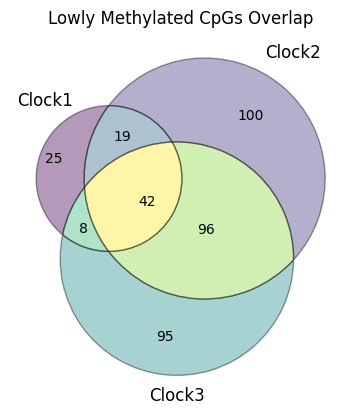

In [233]:
### Venn diagram of lowly methylated CpGs across clocks
 
# Select the CpGs that are lowly methylated in each clock
venn = venn3([low_methylated_sets['clock1'], low_methylated_sets['clock2'], low_methylated_sets['clock3']],
      ('Clock1', 'Clock2', 'Clock3'))

# Apply the viridis colormap
viridis = colormaps.get_cmap('viridis')  # Get the viridis colormap

# Generate 7 colors from the colormap
colors = [viridis(i / 6) for i in range(7)]

# Set colors for the Venn diagram areas
for i, patch in enumerate(venn.patches):
    if patch is not None:
        patch.set_color(colors[i])
        patch.set_edgecolor('black')  # Optionally add a border for better visualization
        
plt.title('Lowly Methylated CpGs Overlap')
plt.show()

### 2.4. Variable Methylation CpGs in All Tissues

In [247]:
### CpGs with highly variable methylation in all clocks

# Get the set of CpGs with highly variable methylation for each clock
variable_methylated_sets = {clock: set(df['CpG']) for clock, df in variable_methylation_cpgs.items()}

# Convert the CpGs to strings to avoid hash errors and exclude clock2_3
clock1 = set(str(cpg) for cpg in variable_methylated_sets['clock1'])
clock2 = set(str(cpg) for cpg in variable_methylated_sets['clock2'])
clock3 = set(str(cpg) for cpg in variable_methylated_sets['clock3'])
# clock2_3 = set(str(cpg) for cpg in variable_methylated_sets['clock2_3']) # Not used at it already is an overlap of two clocks

# Find the intersection of all sets
all_clocks_variable_methylated_cpgs = set.intersection(clock1, clock2, clock3) #instead of set.intersection(*variable_methylated_sets.values()) as this pulls all the clocks and I dont want to include clock2_3

# Convert the result to a list if needed
all_clocks_variable_methylated_cpgs = list(all_clocks_variable_methylated_cpgs)

# Set the output folder
output_folder = 'Cross-Tissue Methylation Patterns'
os.makedirs(output_folder, exist_ok=True)

# save the list to a csv file
all_clocks_variable_methylated_cpgs_df = pd.DataFrame(all_clocks_variable_methylated_cpgs, columns=['CpG'])
all_clocks_variable_methylated_cpgs_df.to_csv(os.path.join(output_folder, 'all_clocks_variable_methylated_cpgs.csv'), index=False)

# Print the result
print(f"\nNumber of CpGs consistently highly variable methylation across all clocks: {len(all_clocks_variable_methylated_cpgs)}")
print("CpGs consistently highly variable methylation across all clocks:")
print(all_clocks_variable_methylated_cpgs)


Number of CpGs consistently highly variable methylation across all clocks: 81
CpGs consistently highly variable methylation across all clocks:
['cg19981759', 'cg11084334', 'cg12830057', 'cg09360996', 'cg27201382', 'cg15437942', 'cg07005811', 'cg01429475', 'cg02909927', 'cg07323940', 'cg19195912', 'cg26844246', 'cg17437489', 'cg21907062', 'cg17516812', 'cg08563010', 'cg23087015', 'cg12841266', 'cg08938156', 'cg17357006', 'cg17114460', 'cg27547112', 'cg03820088', 'cg17267107', 'cg04706544', 'cg18304538', 'cg13608832', 'cg26709300', 'cg01169686', 'cg17116410', 'cg14361875', 'cg19090691', 'cg11690941', 'cg10501210', 'cg27228973', 'cg26072749', 'cg13188467', 'cg15340018', 'cg20615601', 'cg21633990', 'cg01975510', 'cg06472065', 'cg09461098', 'cg12156848', 'cg05844902', 'cg10439738', 'cg12382554', 'cg15809488', 'cg11235379', 'cg11666770', 'cg08446005', 'cg14701342', 'cg03942000', 'cg18168101', 'cg18094982', 'cg11948733', 'cg15746205', 'cg17718834', 'cg13935553', 'cg14443903', 'cg23415880', '

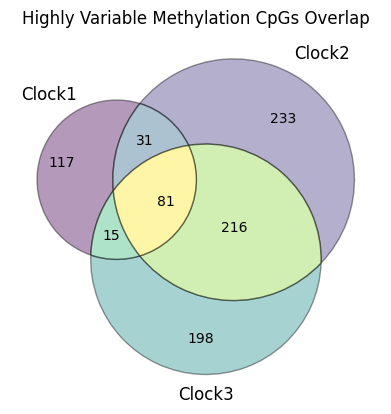

In [235]:
### Venn diagram of CpGs with highly variable methylation across clocks

# Select the CpGs with highly variable methylation for each clock
venn = venn3([variable_methylated_sets['clock1'], variable_methylated_sets['clock2'], variable_methylated_sets['clock3']],
        ('Clock1', 'Clock2', 'Clock3'))

# Apply the viridis colormap
viridis = colormaps.get_cmap('viridis')  # Get the viridis colormap

# Generate 7 colors from the colormap
colors = [viridis(i / 6) for i in range(7)]

# Set colors for the Venn diagram areas
for i, patch in enumerate(venn.patches):
    if patch is not None:
        patch.set_color(colors[i])
        patch.set_edgecolor('black')  # Optionally add a border for better visualization

plt.title('Highly Variable Methylation CpGs Overlap')
plt.show()

### 2.5. CpGs that are significantly differentially methylated between tissues in each clock

In [236]:
### Summary of significant CpGs from ANOVA

# Define the clocks and their file paths
clocks_sig_path = {
    'clock1': 'Cross-Tissue Methylation Patterns/clock1/clock1_significant_cpgs.csv',
    'clock2': 'Cross-Tissue Methylation Patterns/clock2/clock2_significant_cpgs.csv',
    'clock3': 'Cross-Tissue Methylation Patterns/clock3/clock3_significant_cpgs.csv',
    'clock2_3': 'Cross-Tissue Methylation Patterns/clock2_3/clock2_3_significant_cpgs.csv'
}

clock_significant_cpgs = {}

for clock_name, file_path in clocks_sig_path.items():
        
        # Load the significant CpGs for each clock
        significant_cpgs = pd.read_csv(file_path, index_col=0)

        # Store the significant CpGs in a dictionary
        clock_significant_cpgs[clock_name] = significant_cpgs

        # Rename columns from 0 to 'p-value'
        clock_significant_cpgs[clock_name].columns = ['p-value']

        print(f"\n{clock_name.upper()} CLOCK:")
        print(f"Number of significant CpGs: {clock_significant_cpgs.get(clock_name).shape[0]}")
        # print(f"Significant CpGs:\n{clock_significant_cpgs}")


CLOCK1 CLOCK:
Number of significant CpGs: 42

CLOCK2 CLOCK:
Number of significant CpGs: 76

CLOCK3 CLOCK:
Number of significant CpGs: 59

CLOCK2_3 CLOCK:
Number of significant CpGs: 31


### 2.6. CpGs that are significantly differentially methylated between tissues in all clocks

In [237]:
### CpGs that are significant in all clocks - vary significantly across tissues

significant_cpgs_all = {clock: set(df.index) for clock, df in clock_significant_cpgs.items()}

# Convert the CpGs to strings to avoid hash errors snd exclude clock2_3
clock1 = set(str(cpg) for cpg in clock_significant_cpgs['clock1'].index)
clock2 = set(str(cpg) for cpg in clock_significant_cpgs['clock2'].index)
clock3 = set(str(cpg) for cpg in clock_significant_cpgs['clock3'].index)
# clock2_3 = set(str(cpg) for cpg in clock_significant_cpgs['clock2_3'].index)

# Find the intersection of all sets
all_clocks_significant_cpgs = set.intersection(clock1, clock2, clock3) #instead of set.intersection(*significant_cpgs_all.values()) as this pulls all the clocks and I dont want to include clock2_3

# Select folder to save the results
folder_name = 'Cross-Tissue Methylation Patterns'
os.makedirs(folder_name, exist_ok=True)

# Save the results to a CSV file
anova_all_clocks_significant_cpgs = pd.DataFrame(all_clocks_significant_cpgs, columns=['CpG'])
anova_all_clocks_significant_cpgs.to_csv(os.path.join(folder_name, 'anova_all_clocks_significant_cpgs.csv'), index=False)


print(f"\nNumber of CpGs significant in all clocks: {len(all_clocks_significant_cpgs)}")
print(f"\nCpGs significant in all clocks:")
print(all_clocks_significant_cpgs)


Number of CpGs significant in all clocks: 17

CpGs significant in all clocks:
{'cg23087015', 'cg27228973', 'cg07323940', 'cg11516694', 'cg19981759', 'cg11235379', 'cg11084334', 'cg27201382', 'cg26072749', 'cg23415880', 'cg08938156', 'cg13188467', 'cg23510032', 'cg14361875', 'cg15437942', 'cg05844902', 'cg07875786'}


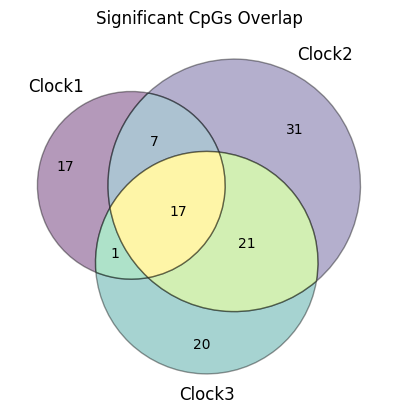

In [238]:
### Venn diagram of significant CpGs across clocks

# Select the CpGs that are significant in each clock
venn = venn3([set(clock_significant_cpgs['clock1'].index), set(clock_significant_cpgs['clock2'].index), set(clock_significant_cpgs['clock3'].index)],
      ('Clock1', 'Clock2', 'Clock3'))

# Apply the viridis colormap
viridis = colormaps.get_cmap('viridis')  # Get the viridis colormap

# Generate 7 colors from the colormap
colors = [viridis(i / 6) for i in range(7)]

# Set colors for the Venn diagram areas
for i, patch in enumerate(venn.patches):
    if patch is not None:
        patch.set_color(colors[i])
        patch.set_edgecolor('black')  # Optionally add a border for better visualization

plt.title('Significant CpGs Overlap')
plt.show()